In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of Oct 2011 - Oct 2012 for the case study

In [3]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')

data_subset = data.reset_index().groupby('item_id').resample('W-Mon', on='date').sum()

In [4]:
data_subset['sell_price'] = data.reset_index().groupby('item_id').resample('W-Mon', on='date').max()['sell_price']

In [5]:
data_subset.reset_index(inplace=True)

Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [6]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-4:-1]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


alt.Chart(...)

In [7]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item

get_input_item(item_id='FOODS_3_555').head()

,item_id,date,sell_price,wday,snap_CA,snap_TX,snap_WI,sales,special_events,sin_wday,cos_wday
14978,FOODS_3_555,2011-01-31,1.48,6.0,0.0,0.0,0.0,850.0,0.0,2.190643e+00,-5.000000e-01
14979,FOODS_3_555,2011-02-07,1.48,28.0,7.0,5.0,4.0,1872.0,1.0,-2.220446e-16,-2.220446e-16
14980,FOODS_3_555,2011-02-14,1.48,28.0,3.0,4.0,5.0,2040.0,1.0,-2.220446e-16,-2.220446e-16
14981,FOODS_3_555,2011-02-21,1.48,28.0,0.0,1.0,1.0,2035.0,1.0,-2.220446e-16,-2.220446e-16
14982,FOODS_3_555,2011-02-28,1.48,28.0,0.0,0.0,0.0,1916.0,0.0,-2.220446e-16,-2.220446e-16


In [8]:
def estimateSignificantLags(ts, nlags = 100, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1  39  50  51  64  75  77  86  89 100]


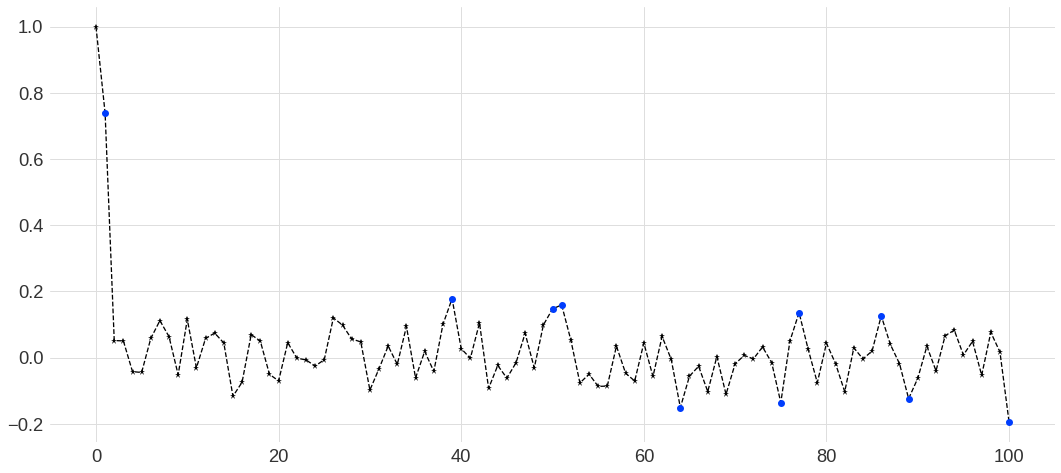

In [9]:
lags = estimateSignificantLags(get_input_item(item_id='FOODS_3_090').sales, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

## Building prediction models

In [10]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 1
    
    if future_covs == False:
        print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*7)]
    else:
        return res_df
    #return res_df

In [74]:
"""input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), value_cols=['sales'])
future = TimeSeries.from_dataframe(get_input_item('FOODS_3_090'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
input_train, _ = input_timeseries.split_before(0.33)

naive_model_weekly = NaiveSeasonal(K=1)
naive_model_weekly.fit(input_train)

get_historical_forecasts(naive_model_weekly,
                         input_timeseries=input_timeseries,
                         model_display_name = naive_model_weekly,
                         future_covariates=future,
                         future_covs = False)"""

"input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), value_cols=['sales'])\nfuture = TimeSeries.from_dataframe(get_input_item('FOODS_3_090'), \n                                       value_cols=['sin_wday','cos_wday','special_events'])\ninput_train, _ = input_timeseries.split_before(0.33)\n\nnaive_model_weekly = NaiveSeasonal(K=1)\nnaive_model_weekly.fit(input_train)\n\nget_historical_forecasts(naive_model_weekly,\n                         input_timeseries=input_timeseries,\n                         model_display_name = naive_model_weekly,\n                         future_covariates=future,\n                         future_covs = False)"

In [12]:
def create_forecast_for_item(itemid):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), value_cols=['sales'])

    future = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
    
    print(future)
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=[-1,-39,-50,-51])
    regr_model_lags.fit(input_train)

    regr_model_cov = RegressionModel(lags=[-1,-2,-5,-6,-7],
                                     lags_future_covariates=[-14,-7,-2,-5,-1,0,1,2,5,7])
    regr_model_cov.fit(input_train,future_covariates=future)

    lgbm_model_cov = LightGBMModel(lags=list(range(-14,0)),
                                   lags_future_covariates=[0,1,2,3,4,5,6,7],
                                   boosting_type='gbdt', 
                                   num_leaves=20, 
                                   max_depth=- 1, 
                                   learning_rate=0.01, 
                                   n_estimators=300)
    
    lgbm_model_cov.fit(input_train,
                       future_covariates=future)

    lgbm_model = LightGBMModel(lags=[-1,-2,-5,-6,-7],
                               boosting_type='gbdt', 
                               num_leaves=20, 
                               max_depth=- 1, 
                               learning_rate=0.01, 
                               n_estimators=300)
    
    lgbm_model.fit(input_train)
    
    theta_model =  Theta(2, 
                         seasonality_period=7, 
                         season_mode=SeasonalityMode.MULTIPLICATIVE)
    
    theta_model.fit(input_train)
    
    fft_model =  FFT(nr_freqs_to_keep=7, 
                     required_matches=set(), 
                     trend='exp')

    fft_model.fit(input_train)
    
    #arima_model = ARIMA(p=1, d=1, q=1, seasonal_order=(1, 7, 0, 0), random_state=0)
    
    #arima_model.fit(input_train)
    
    models = {'Naive weekly':[naive_model_weekly,False]#,
              #'RegressionModelLags':[regr_model_lags,False],
              #'RegressionModelCov':[regr_model_cov,True],
              #'LGBM_cov':[lgbm_model_cov,True],
              #'LGBM_no_cov':[lgbm_model,False],
              #'Theta':[theta_model,False],
              #'FFT':[fft_model,False],
              #'ARIMA':[arima_model,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates=future,
                                                             future_covs = models[model][1]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [13]:
optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished


In [14]:
optimization_df

,ts,value,prediction_date,model,item_id
0,2012-03-26,2080.0,2012-03-26,Naive weekly,FOODS_3_555
0,2012-04-02,2347.0,2012-04-02,Naive weekly,FOODS_3_555
0,2012-04-09,1769.0,2012-04-09,Naive weekly,FOODS_3_555
0,2012-04-16,1850.0,2012-04-16,Naive weekly,FOODS_3_555
0,2012-04-23,2168.0,2012-04-23,Naive weekly,FOODS_3_555
...,...,...,...,...,...
0,2016-04-04,3403.0,2016-04-04,Naive weekly,FOODS_3_586
0,2016-04-11,2860.0,2016-04-11,Naive weekly,FOODS_3_586
0,2016-04-18,2856.0,2016-04-18,Naive weekly,FOODS_3_586
0,2016-04-25,2940.0,2016-04-25,Naive weekly,FOODS_3_586


In [16]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data_subset.reset_index().set_index(['date','item_id'])['sales']
#fact.loc[:,'FOODS_3_090',:].head()

In [17]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data_subset.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [18]:
alt.Chart(optimization_df).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    tooltip=['model:N','prediction_date:T','value:Q'],
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

## Let's add some models based on noise

In [19]:
noisy_biased_1p = fact.copy()
noisy_biased_1p.model = 'noisy_biased_10p'
noisy_biased_1p.value = 1.1*fact.value

noisy_biased_2p = fact.copy()
noisy_biased_2p.model = 'noisy_biased_20p'
noisy_biased_2p.value = 1.2*fact.value

noisy_biased_3p = fact.copy()
noisy_biased_3p.model = 'noisy_biased_30p'
noisy_biased_3p.value = 1.3*fact.value

noisy_biased_4p = fact.copy()
noisy_biased_4p.model = 'noisy_biased_40p'
noisy_biased_4p.value = 1.4*fact.value

noisy_biased_1n = fact.copy()
noisy_biased_1n.model = 'noisy_biased_10n'
noisy_biased_1n.value = 0.9*fact.value

noisy_biased_2n = fact.copy()
noisy_biased_2n.model = 'noisy_biased_20n'
noisy_biased_2n.value = 0.8*fact.value 

noisy_biased_3n = fact.copy()
noisy_biased_3n.model = 'noisy_biased_30n'
noisy_biased_3n.value = 0.7*fact.value

noisy_biased_4n = fact.copy()
noisy_biased_4n.model = 'noisy_biased_40n'
noisy_biased_4n.value = 0.6*fact.value

optimization_df = optimization_df.append(noisy_biased_1p)
optimization_df = optimization_df.append(noisy_biased_2p)
optimization_df = optimization_df.append(noisy_biased_3p)
optimization_df = optimization_df.append(noisy_biased_4p)
optimization_df = optimization_df.append(noisy_biased_1n)
optimization_df = optimization_df.append(noisy_biased_2n)
optimization_df = optimization_df.append(noisy_biased_3n)
optimization_df = optimization_df.append(noisy_biased_4n)

In [20]:
np.random.seed(42)

noisy_normal_0u_10p = fact.copy()
noisy_normal_0u_10p.model = 'noisy_normal_0u_10p'
noisy_normal_0u_10p.value = fact.value + np.random.uniform(-.1,.1)*fact.value

noisy_normal_0u_20p = fact.copy()
noisy_normal_0u_20p.model = 'noisy_normal_0u_20p'
noisy_normal_0u_20p.value = fact.value + np.random.uniform(-.2,.2)*fact.value

noisy_normal_0u_30p = fact.copy()
noisy_normal_0u_30p.model = 'noisy_normal_0u_30p'
noisy_normal_0u_30p.value = fact.value + np.random.uniform(-.3,.3)*fact.value

noisy_normal_0u_40p = fact.copy()
noisy_normal_0u_40p.model = 'noisy_normal_0u_40p'
noisy_normal_0u_40p.value = fact.value + np.random.uniform(-.4,.4)*fact.value

optimization_df = optimization_df.append(noisy_normal_0u_10p)
optimization_df = optimization_df.append(noisy_normal_0u_20p)
optimization_df = optimization_df.append(noisy_normal_0u_30p)
optimization_df = optimization_df.append(noisy_normal_0u_40p)

In [21]:
np.random.seed(42)

noisy_signal_dependent_10 = fact.copy()
noisy_signal_dependent_10.model = 'noisy_signal_dependent_10'
noisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_20 = fact.copy()
noisy_signal_dependent_20.model = 'noisy_signal_dependent_20'
noisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_30 = fact.copy()
noisy_signal_dependent_30.model = 'noisy_signal_dependent_30'
noisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_40 = fact.copy()
noisy_signal_dependent_40.model = 'noisy_signal_dependent_40'
noisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_signal_dependent_10)
optimization_df = optimization_df.append(noisy_signal_dependent_20)
optimization_df = optimization_df.append(noisy_signal_dependent_30)
optimization_df = optimization_df.append(noisy_signal_dependent_40)

In [22]:
fact['time_since_prediction'] = (fact.ts - fact.prediction_date) / np.timedelta64(1, 'h')
fact

,ts,item_id,value,prediction_date,model,time_since_prediction
0,2012-03-26,FOODS_3_555,2007.0,2012-03-26,Fact,0.0
1,2012-04-02,FOODS_3_555,1908.0,2012-04-02,Fact,0.0
2,2012-04-09,FOODS_3_555,2353.0,2012-04-09,Fact,0.0
3,2012-04-16,FOODS_3_555,2088.0,2012-04-16,Fact,0.0
4,2012-04-23,FOODS_3_555,1871.0,2012-04-23,Fact,0.0
...,...,...,...,...,...,...
640,2016-04-04,FOODS_3_586,2680.0,2016-04-04,Fact,0.0
641,2016-04-11,FOODS_3_586,3007.0,2016-04-11,Fact,0.0
642,2016-04-18,FOODS_3_586,2816.0,2016-04-18,Fact,0.0
643,2016-04-25,FOODS_3_586,2875.0,2016-04-25,Fact,0.0


In [23]:
np.random.seed(42)

noisy_horizon_dependent_10 = fact.copy()
noisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'
noisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_20 = fact.copy()
noisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'
noisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_30 = fact.copy()
noisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'
noisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_40 = fact.copy()
noisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'
noisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_horizon_dependent_10)
optimization_df = optimization_df.append(noisy_horizon_dependent_20)
optimization_df = optimization_df.append(noisy_horizon_dependent_30)
optimization_df = optimization_df.append(noisy_horizon_dependent_40)

### Evaluation function for all item_ids

In [24]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

,model,rmse,rmse_normalized,item_id
0,Naive weekly,281.263792,1.0,FOODS_3_555
1,Fact,0.0,0.0,FOODS_3_555
2,noisy_biased_10p,170.771199,0.607157,FOODS_3_555
3,noisy_biased_20p,341.542399,1.214313,FOODS_3_555
4,noisy_biased_30p,512.313598,1.82147,FOODS_3_555
5,noisy_biased_40p,683.084798,2.428627,FOODS_3_555
6,noisy_biased_10n,170.771199,0.607157,FOODS_3_555
7,noisy_biased_20n,341.542399,1.214313,FOODS_3_555
8,noisy_biased_30n,512.313598,1.82147,FOODS_3_555
9,noisy_biased_40n,683.084798,2.428627,FOODS_3_555


In [25]:
alt.Chart(eval_df, title = 'RMSE for items, by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

In [26]:
(eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/3).reset_index()

,model,rmse_normalized,rmse
0,Fact,0.000000,0.000000
1,Naive weekly,1.000000,424.523358
2,noisy_biased_10n,0.561214,237.153005
3,noisy_biased_10p,0.561214,237.153005
4,noisy_biased_20n,1.122429,474.306010
5,noisy_biased_20p,1.122429,474.306010
6,noisy_biased_30n,1.683643,711.459015
7,noisy_biased_30p,1.683643,711.459015
8,noisy_biased_40n,2.244858,948.612019
9,noisy_biased_40p,2.244858,948.612019


In [27]:
alt.Chart((eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/3).reset_index(),
         title='Average RMSE for all items, by model').mark_bar().encode(
    x=alt.X('model:N'),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [28]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price
optimization_df

,item_id,ts,value,prediction_date,model,time_since_prediction,sell_price,daily_revenue
0,FOODS_3_555,2012-03-26,2080.000000,2012-03-26,Naive weekly,NaN,1.595887,3319.443972
1,FOODS_3_555,2012-04-02,2347.000000,2012-04-02,Naive weekly,NaN,1.595887,3745.545674
2,FOODS_3_555,2012-04-09,1769.000000,2012-04-09,Naive weekly,NaN,1.595887,2823.123262
3,FOODS_3_555,2012-04-16,1850.000000,2012-04-16,Naive weekly,NaN,1.595887,2952.390071
4,FOODS_3_555,2012-04-23,2168.000000,2012-04-23,Naive weekly,NaN,1.595887,3459.881986
...,...,...,...,...,...,...,...,...
14185,FOODS_3_586,2016-04-04,2981.180634,2016-04-04,noisy_horizon_dependent_40,0.0,1.595922,4757.731718
14186,FOODS_3_586,2016-04-11,4159.236971,2016-04-11,noisy_horizon_dependent_40,0.0,1.595922,6637.817726
14187,FOODS_3_586,2016-04-18,3049.149247,2016-04-18,noisy_horizon_dependent_40,0.0,1.595922,4866.204321
14188,FOODS_3_586,2016-04-25,2547.972393,2016-04-25,noisy_horizon_dependent_40,0.0,1.595922,4066.365162


In [29]:
#weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = optimization_df.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [30]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [31]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 1
        self.DECISION_TIMESTEP = 1
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        self.BASIC_PRICES = items_prices
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        #w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #2% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data['prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=1000)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [32]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [ ]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done   2 out of  22 | elapsed: 37.6min remaining: 376.1min
[Parallel(n_jobs=-1)]: Done   3 out of  22 | elapsed: 37.6min remaining: 238.4min
[Parallel(n_jobs=-1)]: Done   4 out of  22 | elapsed: 37.8min remaining: 170.0min
[Parallel(n_jobs=-1)]: Done   5 out of  22 | elapsed: 37.8min remaining: 128.7min
[Parallel(n_jobs=-1)]: Done   6 out of  22 | elapsed: 37.9min remaining: 100.9min
[Parallel(n_jobs=-1)]: Done   7 out of  22 | elapsed: 38.0min remaining: 81.3min
[Parallel(n_jobs=-1)]: Done   8 out of  22 | elapsed: 38.0min remaining: 66.6min
[Parallel(n_jobs=-1)]: Done   9 out of  22 | elapsed: 38.1min remaining: 55.0min
[Parallel(n_jobs=-1)]: Done  10 out of  22 | elapsed: 38.2min remaining: 45.8min


In [ ]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [ ]:
result_df.head()

In [ ]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

## Inventory:
 * After predicting the demand N with discount we'll buy 1.1*N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [ ]:
#result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
#result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_df['inventory_left'] = 1.1*result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_df['final_profit_w_discount'] = result_df['daily_profit_w_disount_fact']
result_df['final_profit_base_price'] = result_df['daily_profit_fact']


# if inventory_left>0 substract 40% of it's price from profits
result_df.loc[result_df.inventory_left>0,'final_profit_w_discount']  = result_df.loc[result_df.inventory_left>0,'daily_profit_w_disount_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4
result_df.loc[result_df.inventory_left>0,'final_profit_base_price']  = result_df.loc[result_df.inventory_left>0,'daily_profit_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_df.loc[result_df.inventory_left<0,'final_profit_w_discount'] = result_df.loc[result_df.inventory_left<0,'daily_profit_w_disount_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price_w_disount']
result_df.loc[result_df.inventory_left<0,'final_profit_base_price'] = result_df.loc[result_df.inventory_left<0,'daily_profit_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price']

result_df.head()

In [ ]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_df.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

In [ ]:
"""alt.Chart(result_df.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()"""

In [ ]:
discounts_freq = result_df.reset_index().groupby(['model','disount']).count()['item_id'].reset_index()

alt.Chart(discounts_freq).mark_bar().encode(
    x='model:N',
    y=alt.Y('item_id:Q'),
    color=alt.Color('model:N'),
    #row='model:N',
    column='disount:N'
).properties(width=80, height=400)#.interactive()

In [ ]:
result_df

In [ ]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_df.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']
eval_df.reset_index(inplace=True)

In [ ]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=250, height=250)#.interactive()

## Evaluation for all items in total

In [ ]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.loc['Fact','final_profit_base_price'])/all_items_eval.loc['Fact','final_profit_base_price']
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']


In [ ]:
result_df['disount'].plot.hist()

In [ ]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

In [ ]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [ ]:
all_items_eval

In [ ]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + fact_line

In [ ]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

In [ ]:
all_items_eval